In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
import pyccl.nl_pt as pt
import pyccl.ccllib as lib
from astropy import units as u
from astropy.coordinates import Angle
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


/global/common/software/lsst/common/miniconda/prod/envs/desc/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Preliminaries
Setting up a cosmology and defining the redshift distribution

In [2]:
cosmo = ccl.Cosmology(
    Omega_c=0.22, Omega_b=0.0448, 
    h=0.71, sigma8 = 0.801, n_s= 0.963,w0=-1.00,wa=0.0, Omega_k=0.0)

In [3]:
nzs=np.loadtxt("/global/u1/d/dlan/SkySim5000_IA_infusion/StageIV_zcen_nz_bin1-5.dat", unpack = True)

In [4]:
z=nzs[0]
nzs_s=nzs[1:]

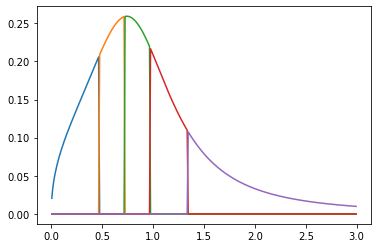

In [5]:
for i in range(len(nzs_s)):
    plot(z,nzs_s[i])

# IA normalization
these factors absorb the typical normalization factors used in the literature for intrinsic alignment amplitude and redshift evolution.

In [6]:
# Biases for IAs. Will be converted to the input c_IA values below.
a_1 = 1.
a_2 = 0.5
a_d = 0.5

In [7]:
c_1,c_d,c_2 = pt.translate_IA_norm(cosmo, z, a1=a_1, a1delta=a_d, a2=a_2,
                                   Om_m2_for_c2 = False)

# Tracers
Let's create the 3 PTTracers

In [8]:
# Intrinsic alignments
ptt_i = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1), c2=(z,c_2), cdelta=(z,c_d))
ptt_i_nla = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1)) # to compare using the standard WLTracer

# Matter
ptt_m = pt.PTMatterTracer()


In [9]:
ptc = pt.PTCalculator(with_NC=True, with_IA=True,
                      log10k_min=-4, log10k_max=2, nk_per_decade=20)

# PT power spectra

In [10]:
# IAs x IAs
pk_ii, pk_ii_bb = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_i, ptc=ptc, return_ia_ee_and_bb=True)
pk_ii_nla = pt.get_pt_pk2d(cosmo, ptt_i_nla, tracer2=ptt_i_nla, ptc=ptc,)

# IAs x matter
pk_im = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_m, ptc=ptc)

# Matter x matter
pk_mm = pt.get_pt_pk2d(cosmo, ptt_m, tracer2=ptt_m, ptc=ptc)

In [11]:
ks = np.logspace(-3,2,512)
ps = {}
ps['ii'] = pk_ii.eval(ks, 1., cosmo)
ps['im'] = pk_im.eval(ks, 1., cosmo)
ps['mm'] = pk_mm.eval(ks, 1., cosmo)

# Angular power spectra

In [12]:
# Lensing
tracers_len = []
for i in range(len(nzs_s)):
    t_l = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[i]))
    tracers_len.append(t_l)


In [13]:
# Intrinsic alignments
tracers_IA = []
for i in range(len(nzs_s)):
    t_i = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[i]), has_shear=False, ia_bias=(z, np.ones_like(z)), use_A_ia=False)
    tracers_IA.append(t_i)

In [14]:
# Intrinsic alignments
tracers_IA_nla = []
for i in range(len(nzs_s)):
    t_i_nla = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[i]), has_shear=False, ia_bias=(z, np.ones_like(z)), use_A_ia=True)
    tracers_IA_nla.append(t_i_nla)

In [15]:
# ell = np.unique(np.geomspace(2,1000,100).astype(int)).astype(float)
# cls={}
# cls['GG'] = np.stack([
#     ccl.angular_cl(cosmo, t, t, ell,p_of_k_a=pk_mm) for t in  tracers_len   
# ])


# cls['II'] =np.stack([
#     ccl.angular_cl(cosmo, t, t, ell,p_of_k_a=pk_ii) for t in tracers_IA    
# ])

# cls['II,NLA'] =np.stack([
#     ccl.angular_cl(cosmo, t, t, ell) for t in tracers_IA_nla    
# ])

In [16]:
ell = np.unique(np.geomspace(2,1000,100).astype(int)).astype(float)
cls={}


cross=[]
for i in range(5):
    for j in range(5):
        cross.append(ccl.angular_cl(cosmo, tracers_len[i], tracers_len[j], ell,p_of_k_a=pk_mm))
cls['GG'] = np.stack(cross)

cross=[]
for i in range(5):
    for j in range(5):
        cross.append(ccl.angular_cl(cosmo, tracers_IA[i], tracers_IA[j], ell,p_of_k_a=pk_ii))
cls['II'] = np.stack(cross)

cross=[]
for i in range(5):
    for j in range(5):
        cross.append(ccl.angular_cl(cosmo, tracers_IA_nla[i], tracers_IA_nla[j], ell))
cls['II,NLA'] = np.stack(cross)

# Shear correlation function

In [17]:
theta =np.unique(np.geomspace(2,100,1000).astype(int)).astype(float)

In [18]:
theta_arc=Angle(theta, u.arcmin)

In [19]:
shear_GG_plus=[]
for i in range(25): 
    shear_GG_plus.append(ccl.correlation(cosmo, ell, cls['GG'][i] ,theta_arc.deg , corr_type='L+', method='fftlog'))
shear_GG_plus=np.stack(shear_GG_plus)

/global/common/software/lsst/common/miniconda/prod/envs/desc/lib/python3.8/site-packages/pyccl/correlations.py:83: CCLWarning: corr_type is deprecated. Use type = GG+
  warnings.warn("corr_type is deprecated. Use type = {}".format(type),


In [20]:
shear_GG_minus=[]
for i in range(25): 
    shear_GG_minus.append(ccl.correlation(cosmo, ell, cls['GG'][i] ,theta_arc.deg, corr_type='L-', method='fftlog'))
shear_GG_minus=np.stack(shear_GG_minus)

/global/common/software/lsst/common/miniconda/prod/envs/desc/lib/python3.8/site-packages/pyccl/correlations.py:83: CCLWarning: corr_type is deprecated. Use type = GG-
  warnings.warn("corr_type is deprecated. Use type = {}".format(type),


In [21]:
shear_II_NLA_plus=[]
for i in range(25): 
    shear_II_NLA_plus.append(ccl.correlation(cosmo, ell,cls['II,NLA'][i] ,theta_arc.deg , corr_type='L+', method='fftlog'))
shear_II_NLA_plus=np.stack(shear_II_NLA_plus)

In [22]:
shear_II_NLA_minus=[]
for i in range(25): 
    shear_II_NLA_minus.append(ccl.correlation(cosmo, ell,cls['II,NLA'][i] ,theta_arc.deg , corr_type='L-', method='fftlog'))
shear_II_NLA_minus=np.stack(shear_II_NLA_minus)

In [23]:
shear_II_plus=[]
for i in range(25): 
    shear_II_plus.append(ccl.correlation(cosmo, ell,cls['II'][i] ,theta_arc.deg , corr_type='L+', method='fftlog'))
shear_II_plus=np.stack(shear_II_plus)

In [24]:
shear_II_minus=[]
for i in range(25): 
    shear_II_minus.append(ccl.correlation(cosmo, ell,cls['II'][i] ,theta_arc.deg , corr_type='L-', method='fftlog'))
shear_II_minus=np.stack(shear_II_minus)

In [25]:

def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
        plt.xlabel(r'$\theta$', fontsize=15)
        plt.ylabel(r'$\xi_+(\theta)$', fontsize=15)
    return axs[:N]

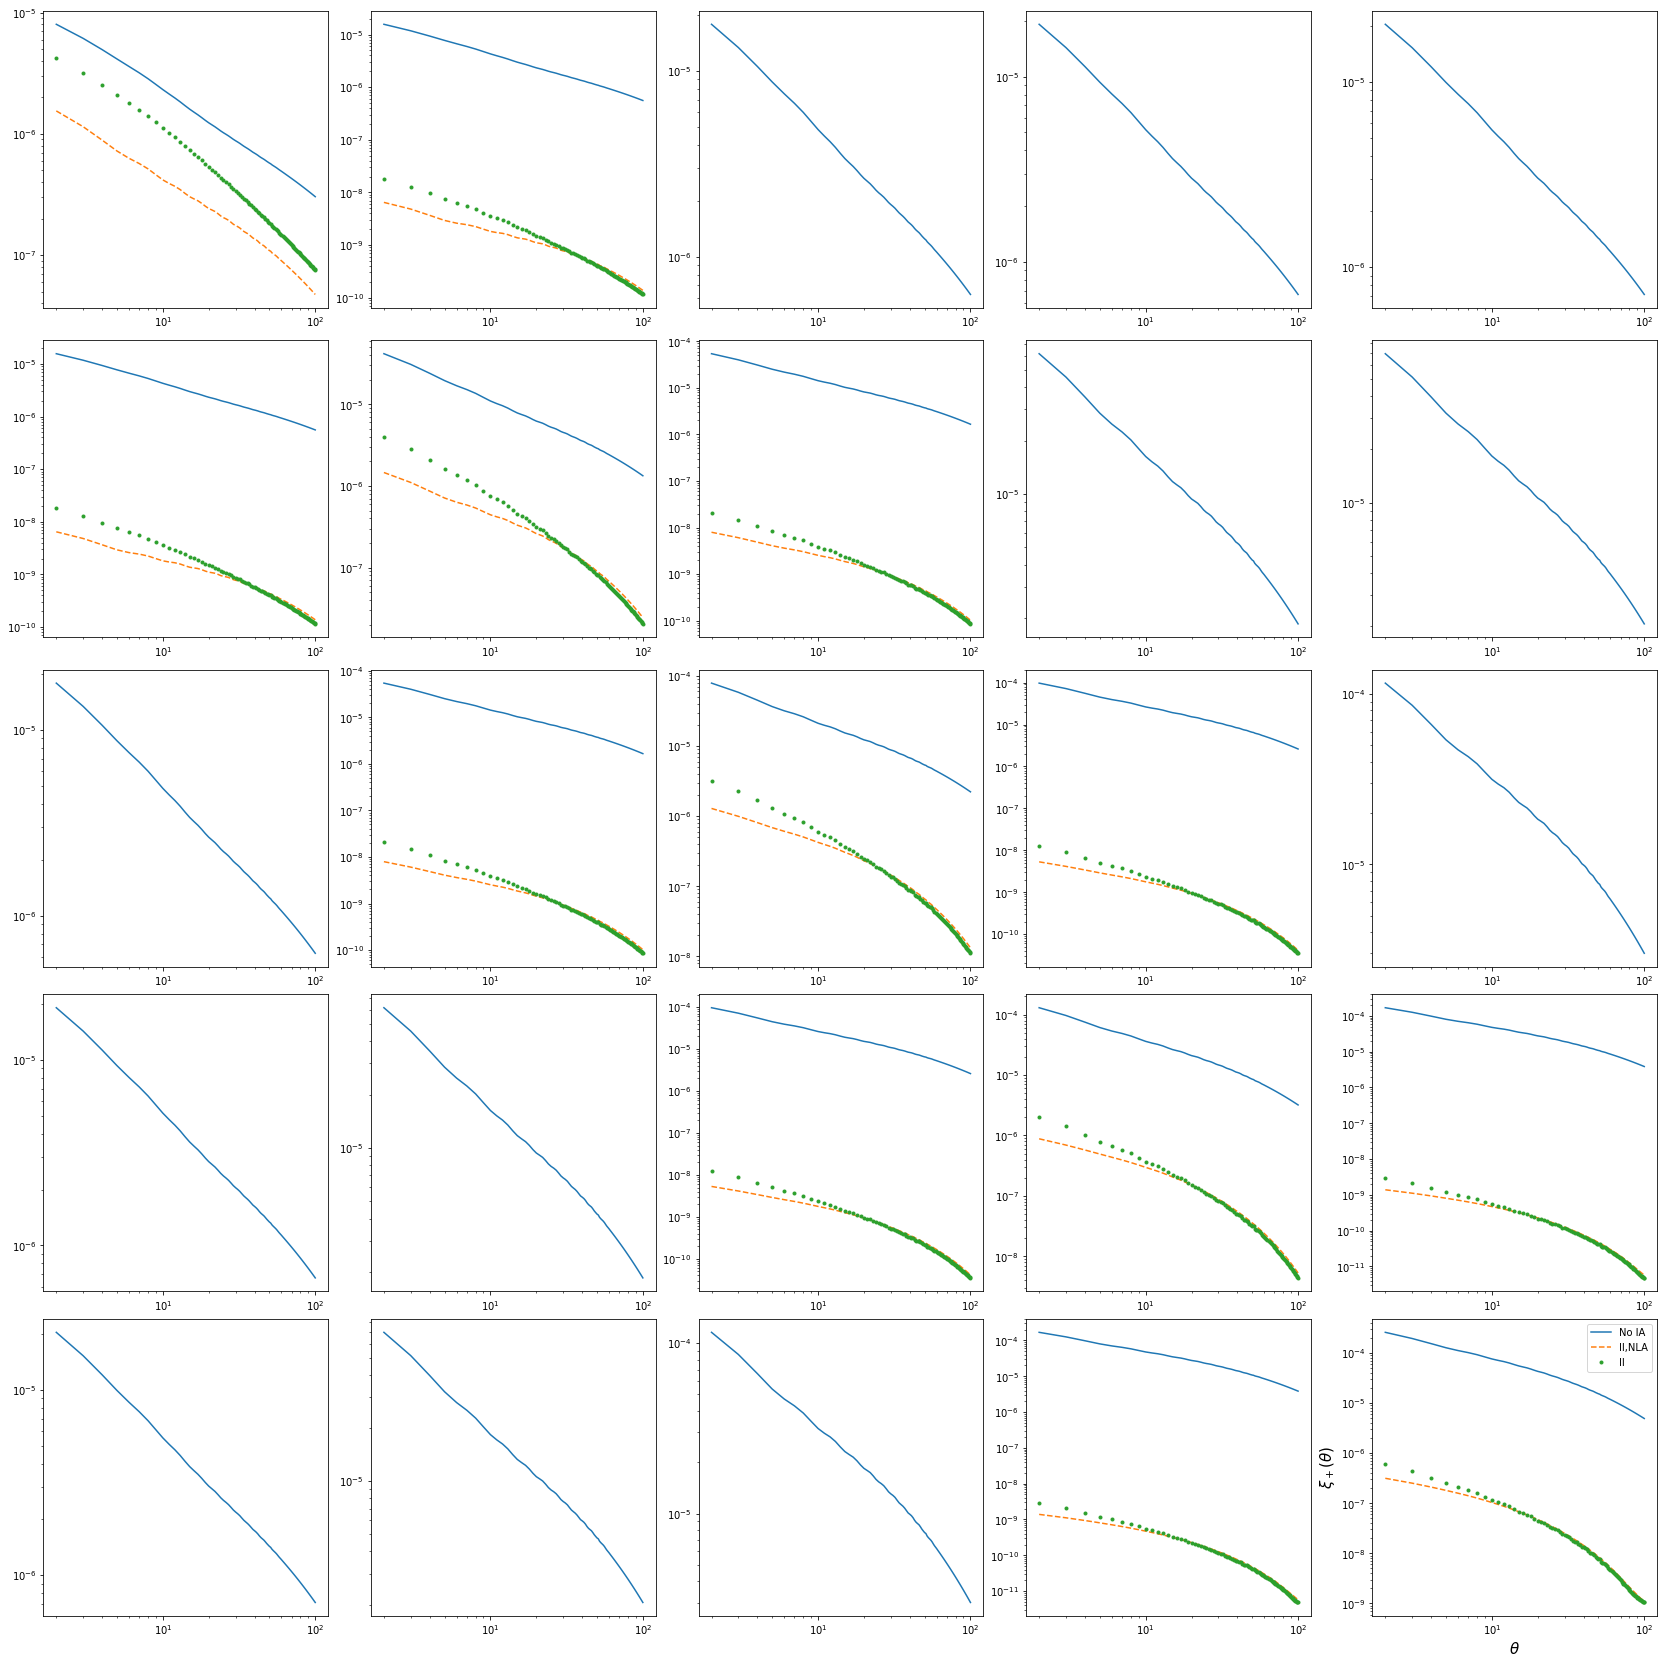

In [26]:
k=theta
figsize = (23, 23)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 5
rows =5
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(shear_GG_plus))
for ax, pi in zip(axs, shear_GG_plus):
    ax.loglog(theta, pi,label='No IA')
for ax, px in zip(axs, shear_II_NLA_plus):
    ax.loglog(theta, px,'--',label='II,NLA')
for ax, pj in zip(axs, shear_II_plus):
    ax.loglog(theta, pj,'.',label='II')
    plt.xlabel(r'$\theta$', fontsize=15)
    plt.ylabel(r'$\xi_+(\theta)$', fontsize=15)
legend(loc='upper right')
#fig.savefig("pos_cross.png",dpi=250)

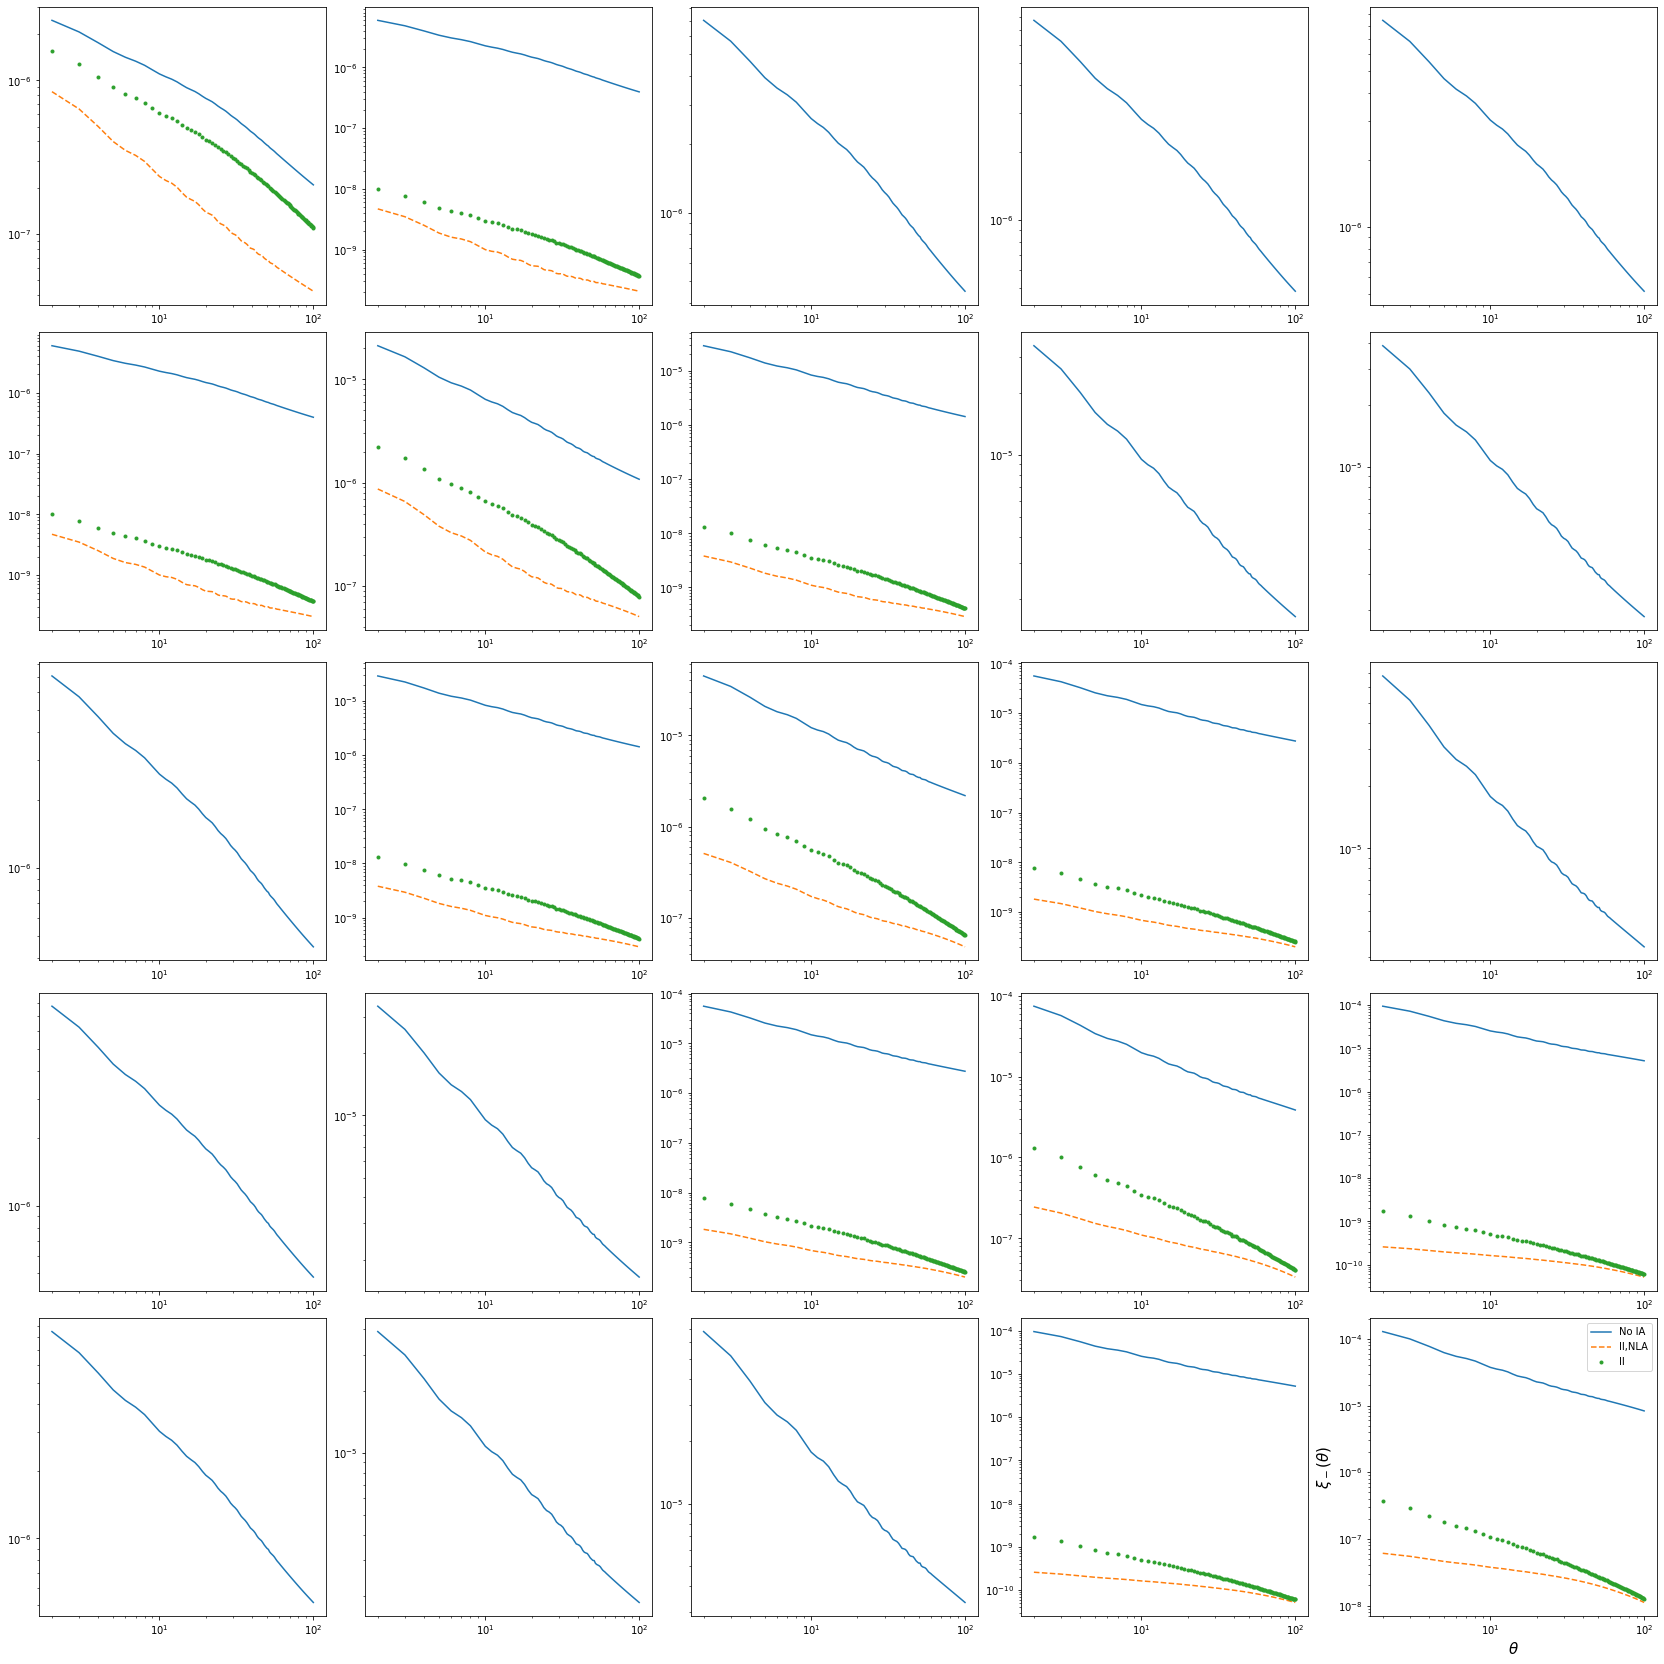

In [28]:
k=theta
figsize = (23, 23)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 5
rows =5
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(shear_GG_minus))

for ax, pi in zip(axs, shear_GG_minus):
    ax.loglog(theta, pi,label='No IA')
for ax, px in zip(axs, shear_II_NLA_minus):
    ax.loglog(theta, px,'--',label='II,NLA')
for ax, pj in zip(axs, shear_II_minus):
    ax.loglog(theta, pj,'.',label='II')
plt.xlabel(r'$\theta$', fontsize=15)
plt.ylabel(r'$\xi_-(\theta)$', fontsize=15)

legend(loc='upper right')
#fig.savefig("neg_cross.png",dpi=250)